In [7]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import math
import csv
filename = '/../Academics/Semester7/BTP/Plotting/Data.csv'

In [8]:
class Arm:
    def __init__(self, alphas, betas, N):
        self.num_attributes = len(alphas)        #Number of attributes
        self.alphas = alphas                            #List of means of each attribute
        self.betas = betas                      #List of standard deviations
        self.mu_hat = np.zeros(self.num_attributes) #List of empirical means
        self.times_pulled = np.zeros(self.num_attributes)                       #Number of times the arm is pulled
        self.lcb_attr = np.zeros(self.num_attributes)
        self.ucb_attr = np.ones(self.num_attributes)
        self.N = N                                  #Number of arms

    def pull(self, att):
        reward = 0
        alpha, beta = self.alphas[att], self.betas[att]
        reward = (np.random.beta(alpha, beta, 1)[0])
        self.mu_hat[att] = ((self.mu_hat[att] * self.times_pulled[att]) + reward) / (self.times_pulled[att] + 1)
        self.times_pulled[att] += 1
        self.lcb_attr = self.lcb(att)
        self.ucb_attr = self.ucb(att)
        return reward                               #List of reward from each attribute

    def hoeffding(self, att, delta):
        c = ((math.pi)**2)/6
        t = self.times_pulled[att]
        log_term = math.log(2 * self.N * c * t * t / delta)
        radius = math.sqrt(2 * log_term / t)
        return radius
    
    def lcb(self, att, delta = 0.2):
        if self.times_pulled[att] == 0:
            lcb_attr = 0
        else:
            lcb_attr = self.mu_hat[att] - self.hoeffding(att, delta)
        self.lcb_attr[att] = lcb_attr
        return self.lcb_attr    #List of LCBs for each attribute
    
    def ucb(self, att, delta = 0.2):
        if self.times_pulled[att] == 0:
            ucb_attr = 1
        else:
            ucb_attr = self.mu_hat[att] + self.hoeffding(att, delta)
        self.ucb_attr[att] = ucb_attr
        return self.ucb_attr    #List of UCBs for each attribute
    
    def arm_lcb(self, delta = 0.2):
        return sum(self.mu_hat) - self.hoeffding(delta)    #LCB for the arm
    
    def arm_ucb(self, delta = 0.2):
        return sum(self.mu_hat) + self.hoeffding(delta)    #UCB for the arm
    
    def reset(self):
        self.mu_hat = np.zeros(self.num_attributes)
        self.times_pulled = np.zeros(self.num_attributes)

In [9]:
class Action_Elimination:
    #Arm_params is of the form [(alpha1, beta1), (alpha2, beta2), ...]. Each aplphai and betai is an array.
    def __init__(self, arm_params, uniform_exp = 10, delta = 0.1, threshold = 0.2):
        self.num_arms = len(arm_params)
        self.arms = [Arm(params[0], params[1], self.num_arms) for params in arm_params]
        #All the arms should have the same number of attributes
        self.num_attributes = self.arms[0].num_attributes
        self.uniform_exp = uniform_exp
        self.delta = delta
        self.threshold = threshold

    def start(self):
        for arm in self.arms:
            arm.reset()
        omega_curr = list(range(self.num_arms))
        while len(omega_curr) > 1:
            for arm_index in omega_curr:
                for att in range(self.num_attributes):
                    # if (self.arms[arm_index]).lcb_attr[att] < self.threshold and (self.arms[arm_index]).ucb_attr[att] > self.threshold: 
                        for _ in range(self.uniform_exp):
                            (self.arms[arm_index]).pull(att)                                                 #Uniform exploration
                # print(self.arms[arm_index].lcb(), self.arms[arm_index].mu_hat, self.arms[arm_index].ucb())
                # print(self.arms[arm_index].arm_lcb(), self.arms[arm_index].arm_ucb())

            ref_arm_index = max(omega_curr, key = lambda index: np.max(self.arms[index].ucb_attr)) #Reference arm
            # print(ref_arm_index)

            omega_next = []
            for arm_index in omega_curr:
                if min((self.arms[arm_index]).ucb_attr) > self.threshold:                        #Threshold condition
                    if sum(self.arms[ref_arm_index].lcb_attr) < sum(self.arms[arm_index].ucb_attr):   #Mean condition
                        omega_next.append(arm_index)
            if len(omega_next) == 0:
                for arm_index in omega_curr:
                    if min((self.arms[arm_index]).ucb_attr[att]) > self.threshold:
                        omega_next.append(arm_index)
            omega_curr = omega_next
            # print(omega_curr)

        if len(omega_curr) > 0:
            return omega_curr[0]
        else:
            return -1  

In [10]:
one = Arm([1, 1], [1, 1], 1)

In [11]:
one.pull(1)
one.hoeffding(1, 0.1)


2.6432678925998916

# Single Instance

## Base Case: 5 Arms

In [85]:
arms_params = np.array([([1, 1], [0.11, 9]),        #0.9, 0.1
                        ([1, 1], [9, 2.33]),        #0.1, 0.3    
                        ([1, 1], [4, 1.5]),         #0.2, 0.4
                        ([1, 1], [1.5, 1.5]),       #0.4, 0.4   - Best arm
                        ([1, 1], [1, 9])])          #0.5, 0.1

N_iter = 100
count = [0 for _ in range (len(arms_params) + 1)]
for i in range (N_iter):
    # print(i)
    ae = Action_Elimination(arms_params)
    best_arm = ae.start()
    # print(best_arm)
    count[best_arm] += 1

count = np.array(count)  
print(count/N_iter)

[0.59 0.   0.   0.41 0.   0.  ]


## Multiple Instances

#### Case 1A

In [22]:
N_iter = 10
samples_ins = []
x_val = []
prob_success = []

for x in [0.65, 0.7, 0.75, 0.8, 0.859, 0.9]:
    arms_params = np.array([([1, 1], [(1/x) - 1, 0.66]),    #x, 0.6   - best arm
                        ([1, 1], [1, 0.66]),                #0.5, 0.6
                        ([1, 1], [4, 0.25]),                #0.2, 0.8
                        ([1, 1], [1.5, 1]),                 #0.4, 0.5
                        ([1, 1], [1, 2.33])])               #0.5, 0.3
    count = [0 for _ in range (len(arms_params) + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.3)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1
    
    delta_i = (x - 0.5)/2
    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(1/delta_i)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done


In [23]:
print(x_val)
print(samples_ins)

[13.333333333333332, 10.000000000000002, 8.0, 6.666666666666666, 5.571030640668524, 5.0]
[array([86782., 86782.]), array([50509., 50509.]), array([35998., 35998.]), array([25417., 25417.]), array([17064., 17064.]), array([13954., 13954.])]


In [24]:
ans = []
for i in range (len(samples_ins)):
    ans.append(samples_ins[i][0])

print(ans)

[86782.0, 50509.0, 35998.0, 25417.0, 17064.0, 13954.0]


In [25]:
with open(filename, 'r') as file:
    # Create a CSV reader object
    reader = csv.reader(file)

    # Create a list to store the rows
    rows = []

    # Iterate over each row in the CSV file
    for row in reader:
        # Append the row to the list
        rows.append(row)

    # Modify the 4th row
    rows[0] = x_val
    rows[1] = ans

# Open the CSV file in write mode
with open(filename, 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the modified rows to the CSV file
    writer.writerows(rows)

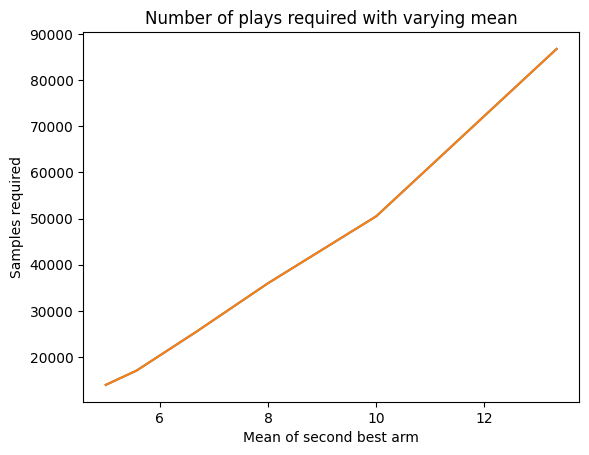

In [26]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

In [27]:
print(samples_ins)

[array([86782., 86782.]), array([50509., 50509.]), array([35998., 35998.]), array([25417., 25417.]), array([17064., 17064.]), array([13954., 13954.])]


In [28]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


#### Case 1B

In [9]:
N_iter = 100
samples_ins = []
x_val = []
prob_success = []

for x in [0.5, 0.55, 0.6, 0.65, 0.7]:
    arms_params = np.array([([1, 1], [(1/x) - 1, 0.01]),   #x, 0.6   - best arm
                        ([1, 1.5], [1, 1.5]),              #0.5, 0.6
                        ([1, 4], [4, 1.5]),                #0.2, 0.8
                        ([1, 1], [9, 1]),                  #0.4, 0.5
                        ([1, 1], [1, 2.33])])              #0.5, 0.3
    count = [0 for _ in range (len(arms_params) + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.3)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    delta_i = (x - 0.5)/2
    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(1/delta_i)
    prob_success.append(count[0]/N_iter)
    print("Done")

KeyboardInterrupt: 

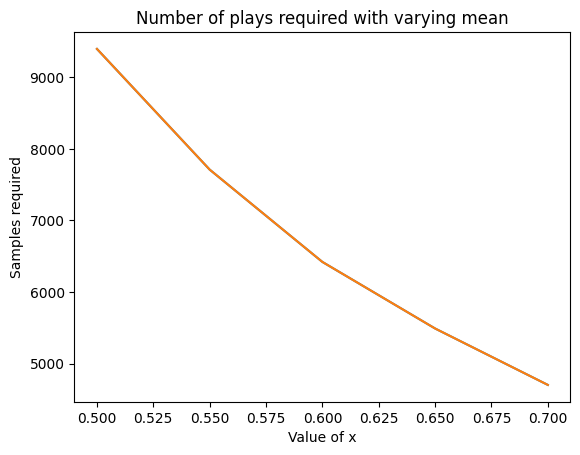

In [87]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

In [88]:
print(samples_ins)

[array([9394.9, 9394.9]), array([7710., 7710.]), array([6420.9, 6420.9]), array([5491.5, 5491.5]), array([4704., 4704.])]


In [89]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0]


#### Case 2

In [8]:
N_iter = 50
samples_ins = []
x_val = []
prob_success = []

for x in [0.5, 0.54, 0.58, 0.62, 0.66, 0.7]:
    arms_params = arms_params = np.array([([1, 1, 1, 1, 1], [0.43, 0.67, 0.25, 0.43, 0.11]), 
                                          ([1, 1, 1, 1, 1], [0.43, (1/x)-1, 0.43, 0.43, 0.25]),     
                                          ([1, 1, 1, 1, 1], [5.66, 0.43, 0.25, 0.11, 0.11]),
                                          ([1, 1, 1, 1, 1], [5.66, 0.11, 0.11, 0.11, 0.25]), 
                                          ([1, 1, 1, 1, 1], [9, 0.11, 0.11, 0.25, 0.25])])
    count = [0 for _ in range (len(arms_params) + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.3)
        best_arm_guess = ae.start()
        samples_all.append(sum([sum(arm.times_pulled) for arm in ae.arms]))
        count[best_arm_guess] += 1

    delta_i = (x - 0.3)/2
    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(1/delta_i)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done


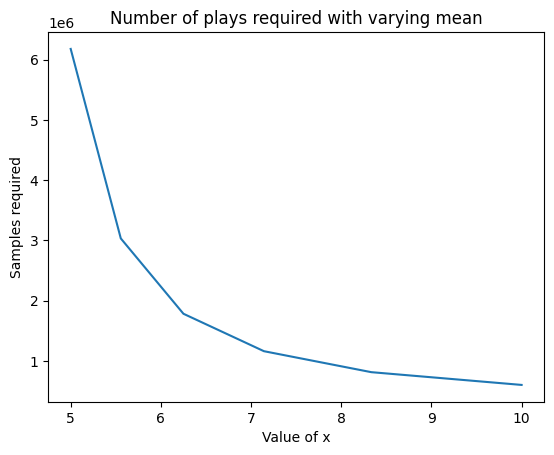

In [13]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

In [31]:
print(x_val)

[13.333333333333332, 10.000000000000002, 8.0, 6.666666666666666, 5.714285714285714, 5.0]


In [9]:
print(samples_ins)

[603596.0, 815147.0, 1162945.0, 1784077.0, 3033363.0, 6176526.0]


#### Case 3

In [14]:
N_iter = 10
samples_ins = []
x_val = []
prob_success = []

for x in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    arms_params = arms_params = np.array([([1, 1, 1, 1, 1], [1, 0.67, 0.67, 1, 0.25]), 
                                          ([1, 1, 1, 1, 1], [0.43, 1, 1.5, 1.5, 0.67]),     
                                          ([1, 1, 1, 1, 1], [(1/x)-1, 1, 0.11, 0.25, 0.11]),
                                          ([1, 1, 1, 1, 1], [0.67, 4, 1.5, 0.43, 0.67]), 
                                          ([1, 1, 1, 1, 1], [2.33, 0.43, 1.5, 0.11, 1])])
    count = [0 for _ in range (len(arms_params) + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.35)
        best_arm_guess = ae.start()
        samples_all.append(sum([sum(arm.times_pulled) for arm in ae.arms]))
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    prob_success.append(count[2]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done


In [17]:
print(samples_ins)

[418855.0, 422130.0, 423395.0, 426590.0, 442945.0, 388275.0]


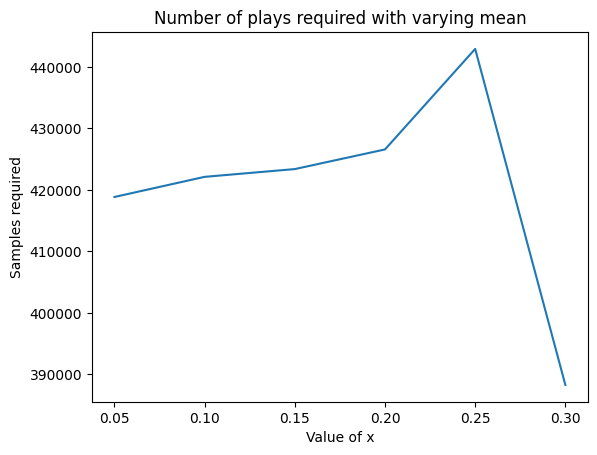

In [15]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

In [63]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


#### Case 4A

In [49]:
N_iter = 50
samples_ins = []
x_val = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    arms_params = np.array([([1, 1], [0.25, 1/x - 1]),    #x, 0.6
                        ([1, 1], [2.33, 1]),                #0.5, 0.6
                        ([1, 1], [1.5, 0.67]),                #0.2, 0.8
                        ([1, 1], [0.25, 1]),                 #0.4, 0.5
                        ([1, 1], [4, 1.5])])               #0.5, 0.3
    count = [0 for _ in range (ae.num_arms + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.4)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done
Done


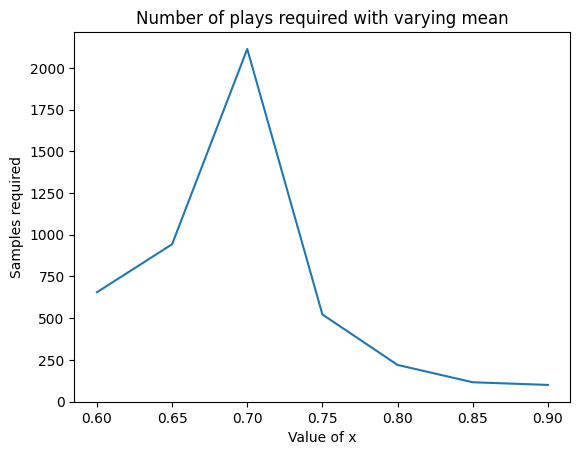

In [50]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 4B

In [ ]:
# self.ab_array[0] = np.array([[1, 0.67], [1, 0.43]])               #0.5
# self.ab_array[1] = np.array([[1, (1/x) - 1], [1, 0.11]])       #0.2
# self.ab_array[2] = np.array([[1, 2.33], [1, 1]])               #0.3
# self.ab_array[3] = np.array([[1, 1], [1, 1]])                  #0.4
# self.ab_array[4] = np.array([[1, 4], [1, 1.5]])                #0.3

In [36]:
N_iter = 10
samples_ins = []
x_val = []
prob_success = []

for x in [0.36, 0.38, 0.4, 0.42, 0.44, 0.45]:
    arms_params = np.array([([1, 1], [0.67, 0.43]),    #x, 0.6
                        ([1, 1], [1/x - 1, 0.11]),                #0.5, 0.6
                        ([1, 1], [2.33, 0.82]),                #0.2, 0.8
                        ([1, 1], [0.82, 0.82]),                 #0.4, 0.5
                        ([1, 1], [4, 1.5])])               #0.5, 0.3
    count = [0 for _ in range (len(arms_params) + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.5)
        best_arm_guess = ae.start()
        # if x == 0.48:
        #     print(best_arm_guess)
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    delta_ij = abs(x-0.5)
    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(1/delta_ij)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done


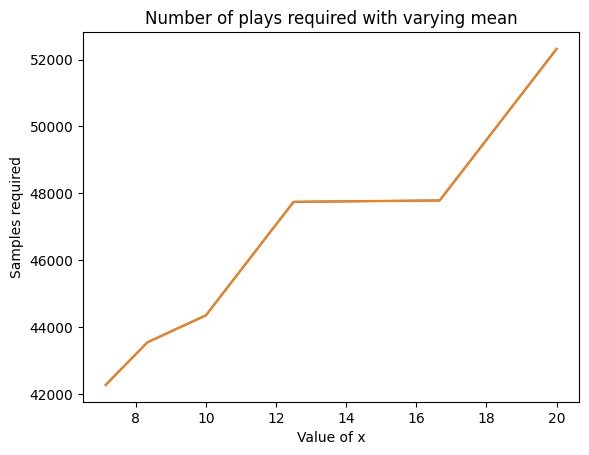

In [37]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

In [39]:
print(samples_ins)

[array([42280., 42280.]), array([43553., 43553.]), array([44358., 44358.]), array([47748., 47748.]), array([47790., 47790.]), array([52316., 52316.])]


In [40]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


# Plotting

In [16]:
# ans = []
# for i in range (len(samples_ins)):
#     ans.append(samples_ins[i][0])

# print(ans)

with open(filename, 'r') as file:
    # Create a CSV reader object
    reader = csv.reader(file)

    # Create a list to store the rows
    rows = []

    # Iterate over each row in the CSV file
    for row in reader:
        # Append the row to the list
        rows.append(row)

    # Modify the 4th row
    # rows[0] = x_val
    rows[1] = samples_ins

# Open the CSV file in write mode
with open(filename, 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the modified rows to the CSV file
    writer.writerows(rows)